# Chapter 19 - Reinforcement Learning for Decision Making in Complex Environments

In [1]:
import gym

env = gym.make('CartPole-v1')
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [2]:
env.action_space

Discrete(2)

In [3]:
env.reset()

array([ 0.04971686,  0.04713945,  0.01196952, -0.04452667])

In [4]:
env.step(action=0)

(array([ 0.05065965, -0.14815207,  0.01107899,  0.25190859]), 1.0, False, {})

In [5]:
env.step(action=1)

(array([ 0.04769661,  0.04680994,  0.01611716, -0.03725933]), 1.0, False, {})

# Implementing the grid world environment in OpenAI Gym

In [6]:
## Script: gridworld_env.py
import numpy as np 
from gym.envs.toy_text import discrete
from collections import defaultdict
import time
import pickle
import os
from gym.envs.classic_control import rendering

CELL_SIZE = 100
MARGIN = 10


def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE // - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = xc - half_size, xc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE // 3
        x2, y2 = xc + CELL_SIZE // 3, yc - CELL_SIZE // 3
        x3, y3 = xc - CELL_SIZE // 3, yc - CELL_SIZE // 3
        return [(x1, y1), (x2, y2), (x3, y3)]
    
    
def draw_object(coords_list):
    if len(coords_list) == 1: # -> circle
        obj = rendering.make_circle(int(0.45 * CELL_SIZE))
        obj_transform = rendering.Transform()
        obj.add_attr(obj_transform)
        obj_transform.set_translation(*coords_list[0])
        obj.set_color(0.2, 0.2, 0.2) # -> balck
    elif len(coords_list) == 3: # -> triangle
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.9, 0.6, 0.2) # -> yellow
    elif len(coords_list) > 3: # -> polygon
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.4, 0.4, 0.8) # -> blue
    return obj


class GridWorldENV(discrete.DiscreteEnv):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.delay = delay
        move_up = lambda row, col: (max(row-1, 0), col)
        move_down = lambda row, col: (min(row+1, num_rows-1), col)
        move_left = lambda row, col: (row, max(col-1, 0))
        move_right = lambda row, col: (row, min(col+1, num_cols-1))
        self.action_defs={0: move_up, 1: move_right,
                          2: move_down, 3: move_left}
        ## Number of states/actions
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict={(s // num_cols, s % num_cols): s for s in range(nS)}
        self.state2grid_dict={s: (s // num_cols, s % num_cols) for s in range(nS)}
        
        ## Gold state
        gold_cell = (num_rows // 2, num_cols - 2)
        
        ## Trap states
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                       (gold_cell[0], gold_cell[1] - 1),
                       ((gold_cell[0] - 1), gold_cell[1])]
        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)] for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states
        print(self.terminal_states)
        ## Build the transition probability
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]
                
                ## Terminal state
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0] else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]
        ## Initial state distribution
        isd = np.zeros(nS)
#         isd[0]
        super().__init__(nS, nA, P, isd)
        self.viewer = None
        self._build_display(gold_cell, trap_cells)
        
    def is_terminal(self, state):
        return state in self.terminal_states
    
    def _build_display(self, gold_cell, trap_cells):
        screen_width = (self.num_cols + 2) * CELL_SIZE
        screen_height = (self.num_rows + 2) * CELL_SIZE
        self.viewer = rendering.Viewer(screen_width,
                                       screen_height)
        all_objects = []
        ## List of border points' coordinates
        bp_list = [
            (CELL_SIZE - MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN,
             screen_height - CELL_SIZE + MARGIN),
            (CELL_SIZE - MARGIN, screen_height - CELL_SIZE + MARGIN)
        ]
        border = rendering.PolyLine(bp_list, True)
        border.set_linewidth(5)
        all_objects.append(border)
        ## Vertical lines
        for col in range(self.num_cols + 1):
            x1, y1 = (col + 1) * CELL_SIZE, CELL_SIZE
            x2, y2 = (col + 1) * CELL_SIZE, \
                     (self.num_rows + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)
            
        ## Horizontal lines
        for row in range(self.num_rows + 1):
            x1, y1 = CELL_SIZE, (row + 1) * CELL_SIZE
            x2, y2 = (self.num_cols + 1) * CELL_SIZE, \
                     (row + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)
            
        ## Traps: --> circles
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            all_objects.append(draw_object([trap_coords]))
            
        ## Gold: --> triangle
        gold_coords = get_coords(*gold_cell,
                                 loc='interior_triangle')
        all_objects.append(draw_object(gold_coords))
        
        ## Agent --> square or robot
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(
                open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(
                0, 0, loc='interior_corners')
            
        agent = draw_object(agent_coords)
        self.agent_trans = rendering.Transform()
        agent.add_attr(self.agent_trans)
        all_objects.append(agent)
        for obj in all_objects:
            self.viewer.add_geom(obj)
            
    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay
        x_coord = self.s % self.num_cols
        y_coord = self.s // self.num_cols
        x_coord = (x_coord + 0) * CELL_SIZE
        y_coord = (y_coord + 0) * CELL_SIZE
        self.agent_trans.set_translation(x_coord, y_coord)
        rend = self.viewer.render(return_rgb_array = (mode=='rgb_array'))
        time.sleep(sleep_time)
        return rend
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
            
            
if __name__ == '__main__':
    env = GridWorldENV(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)
        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Action  ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break
    env.close()

[16, 22, 15, 10]
Action   0 0  ->  (0, 0.0, False, {'prob': 1.0})
Action   0 3  ->  (0, 0.0, False, {'prob': 1.0})
Action   6 2  ->  (6, 0.0, False, {'prob': 1.0})
Action   7 1  ->  (7, 0.0, False, {'prob': 1.0})
Action   13 2  ->  (13, 0.0, False, {'prob': 1.0})
Action   14 1  ->  (14, 0.0, False, {'prob': 1.0})
Action   8 0  ->  (8, 0.0, False, {'prob': 1.0})
Action   14 2  ->  (14, 0.0, False, {'prob': 1.0})
Action   20 2  ->  (20, 0.0, False, {'prob': 1.0})
Action   26 2  ->  (26, 0.0, False, {'prob': 1.0})
Action   27 1  ->  (27, 0.0, False, {'prob': 1.0})
Action   26 3  ->  (26, 0.0, False, {'prob': 1.0})
Action   25 3  ->  (25, 0.0, False, {'prob': 1.0})
Action   25 2  ->  (25, 0.0, False, {'prob': 1.0})
Action   24 3  ->  (24, 0.0, False, {'prob': 1.0})
Action   18 0  ->  (18, 0.0, False, {'prob': 1.0})
Action   24 2  ->  (24, 0.0, False, {'prob': 1.0})
Action   24 3  ->  (24, 0.0, False, {'prob': 1.0})
Action   25 1  ->  (25, 0.0, False, {'prob': 1.0})
Action   25 2  ->  (25, 

# Solving the grid world problem with Q-learning

In [7]:
## Script: agent.py
from collections import defaultdict
import numpy as np


class Agent:
    def __init__(
            self, env,
            learning_rate=0.01,
            discount_factor=0.9,
            epsilon_greedy=0.9,
            epsilon_min=0.1,
            epsilon_decay=0.95):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        ## Define the q_table
        self.q_table = defaultdict(lambda: np.zeros(self.env.nA))

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.env.nA)
        else:
            q_vals = self.q_table[state]
            perm_actions = np.random.permutation(self.env.nA)
            q_vals = [q_vals[a] for a in perm_actions]
            perm_q_argmax = np.argmax(q_vals)
            action = perm_actions[perm_q_argmax]
        return action
    
    def _learn(self, transition):
        s, a, r, next_s, done = transition
        q_val = self.q_table[s][a]
        if done:
            q_target = r
        else:
            q_target = r + self.gamma * np.max(self.q_table[next_s])
        ## Update the q_table
        self.q_table[s][a] += self.lr * (q_target - q_val)
        ## Adjust the epsilon
        self._adjust_epsilon()
        
    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

2
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=2, bias=True)
)
[-0.00799918  0.0407757  -0.02848028  0.03141934]


<ipython-input-8-6b3b5612379f>:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  pred = self.model(torch.tensor(batch_states, dtype=torch.float32))


Episode: 0 / 200, Total reward: 12
Episode: 1 / 200, Total reward: 8
Episode: 2 / 200, Total reward: 9
Episode: 3 / 200, Total reward: 8
Episode: 4 / 200, Total reward: 9
Episode: 5 / 200, Total reward: 8
Episode: 6 / 200, Total reward: 8
Episode: 7 / 200, Total reward: 7
Episode: 8 / 200, Total reward: 9
Episode: 9 / 200, Total reward: 9
Episode: 10 / 200, Total reward: 8
Episode: 11 / 200, Total reward: 8
Episode: 12 / 200, Total reward: 7
Episode: 13 / 200, Total reward: 9
Episode: 14 / 200, Total reward: 9
Episode: 15 / 200, Total reward: 11
Episode: 16 / 200, Total reward: 45
Episode: 17 / 200, Total reward: 110
Episode: 18 / 200, Total reward: 82
Episode: 19 / 200, Total reward: 67
Episode: 20 / 200, Total reward: 58
Episode: 21 / 200, Total reward: 83
Episode: 22 / 200, Total reward: 79
Episode: 23 / 200, Total reward: 152
Episode: 24 / 200, Total reward: 298
Episode: 25 / 200, Total reward: 240
Episode: 26 / 200, Total reward: 362
Episode: 27 / 200, Total reward: 217
Episode: 2

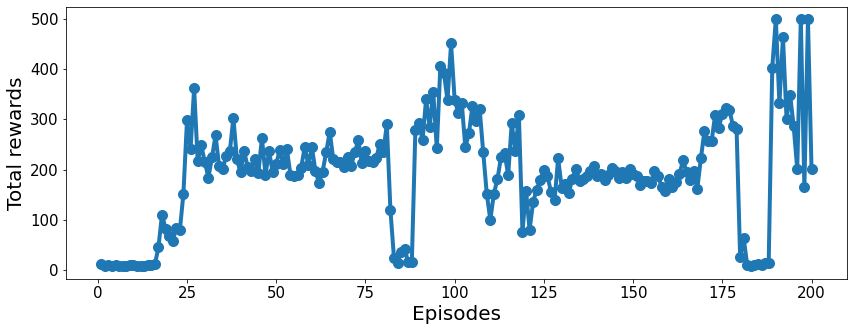

In [8]:

# Implementing a deep Q-learning algorithm

import gym 
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque


np.random.seed(1)
torch.manual_seed(1)

Transition = namedtuple('Transition', 
                       ('state', 'action', 'reward', 'next_state', 'done'))


class DQNAgent:
    def __init__(
            self, env, discount_factor=0.95,
            epsilon_greedy=1.0, epsilon_min=0.01,
            epsilon_decay=0.995, learning_rate=1e-3,
            max_memory_size=2000):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        print(self.action_size)
        self.memory = deque(maxlen=max_memory_size)
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = learning_rate
        self._build_nn_model()
        
    def _build_nn_model(self):
        self.model = nn.Sequential(nn.Linear(self.state_size, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Linear(64, self.action_size))
        print(self.model)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
                                self.model.parameters(), self.lr)
        
    def remember(self, transition):
        self.memory.append(transition)
        
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.tensor(state, 
                                               dtype=torch.float32))[0]
        return torch.argmax(q_values).item()  # returns action
    
    def _learn(self, batch_samples):
        batch_states, batch_targets = [], []

        for transition in batch_samples:
            s, a, r, next_s, done = transition
            
            with torch.no_grad():
                if done:
                    target = r
                else:
                    pred = self.model(torch.tensor(next_s, dtype=torch.float32))[0]
                    target = r + self.gamma * pred.max()
                    
                target_all = self.model(torch.tensor(s,dtype=torch.float32))[0]
                target_all[a] = target
                
            batch_states.append(s.flatten())
            batch_targets.append(target_all)
            self._adjust_epsilon()
            
        self.optimizer.zero_grad()

        pred = self.model(torch.tensor(batch_states, dtype=torch.float32))
        loss = self.loss_fn(pred, torch.stack(batch_targets))

        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def replay(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        return self._learn(samples)
    
    
def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 5))
    ax = fig.add_subplot(1, 1, 1)
    episodes = np.arange(len(history)) + 1
    plt.plot(episodes, history, lw=4,
             marker='o', markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('Total rewards', size=20)
    plt.show()

## General settings
EPISODES = 200
batch_size = 32
init_replay_memory_size = 500


if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    agent = DQNAgent(env)
    
    state = env.reset()
    print(state)
    state = np.reshape(state, [1, agent.state_size])
    
    ## Filling up the replay-memory
    for i in range(init_replay_memory_size):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, agent.state_size])
        agent.remember(Transition(state, action, reward, 
                                  next_state, done))
        if done:
            state = env.reset()
            state = np.reshape(state, [1, agent.state_size])
        else:
            state = next_state
    total_rewards, losses = [], []
    for e in range(EPISODES):
        state = env.reset()
        if e % 10 == 0:
            env.render()
        state = np.reshape(state, [1, agent.state_size])
        for i in range(500):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state,
                                    [1, agent.state_size])
            agent.remember(Transition(state, action, reward,
                                      next_state, done))
            state = next_state
            if e % 10 == 0:
                env.render()
            if done:
                total_rewards.append(i)
                print(f'Episode: {e} / {EPISODES}, Total reward: {i}')
                break
            loss = agent.replay(batch_size)
            losses.append(loss)
    plot_learning_history(total_rewards)
        

In [9]:
x = 1
id(x)

3001423391024

In [10]:
x = x + 1
id(x)

3001423391056

In [11]:
id(x)

3001423391056